### Get Data

- Step 1: Make a path to directory storing Data
- Step 2: Crawl Data from website
- Step 3: Extract zip file
- Step 4: Read it in csv form

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [3]:
def load_housing_data():
    tarball_path = Path("data/housing.tgz")
    if not tarball_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="data")
    return pd.read_csv(Path("data/housing/housing.csv"))

housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> Note:
- dtype of ocean_proximity is objects
- total_bedrooms missed data

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


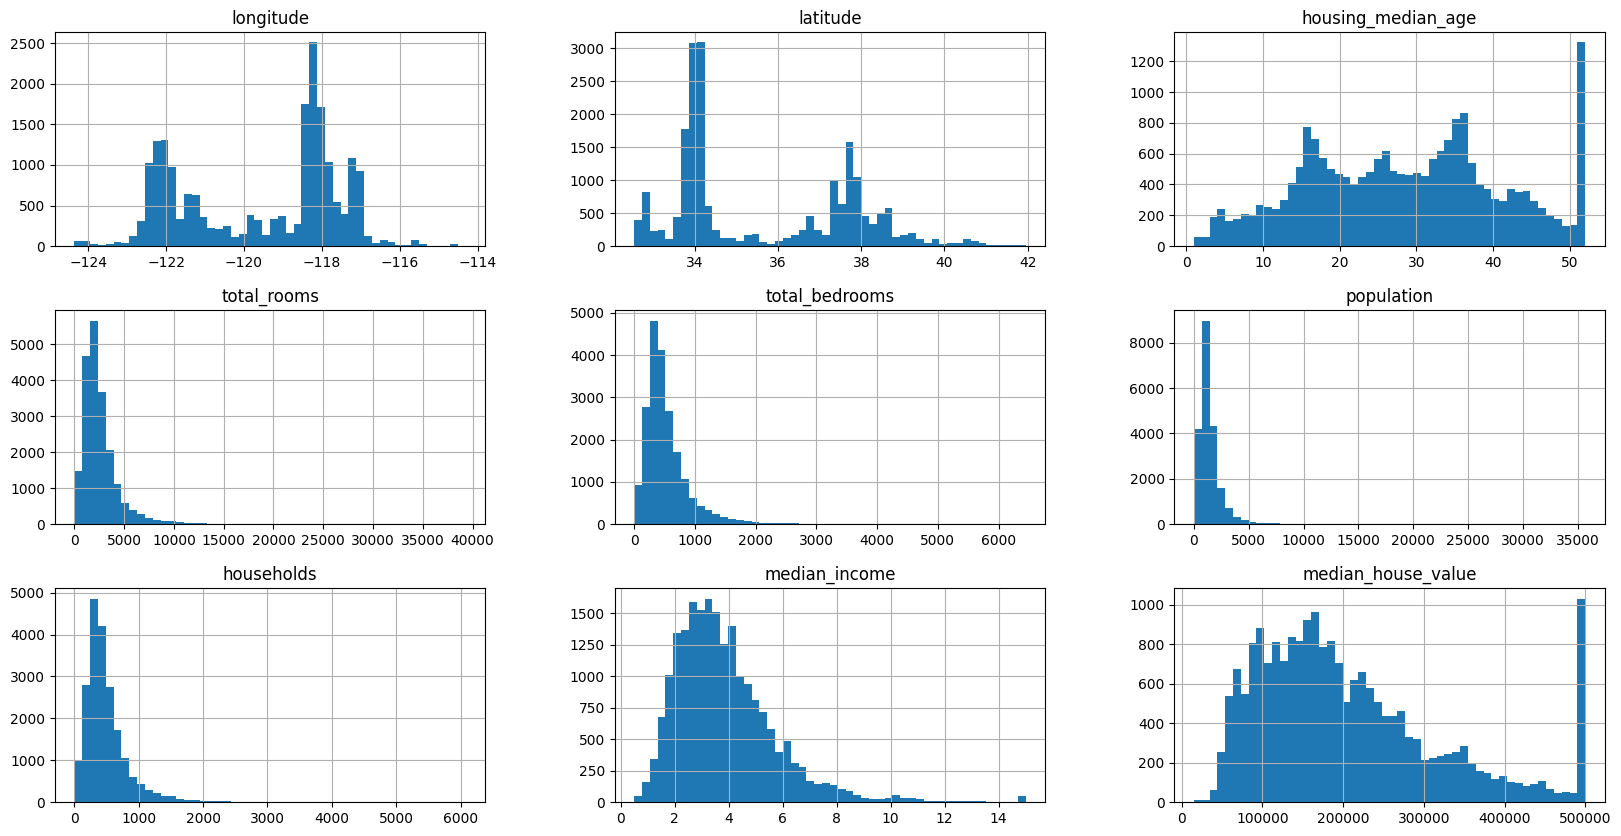

In [15]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,10))
plt.show()

> Note:
- the median income attribute does not express in USD.

Now, we make an split data function to prepare test set.

In [26]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    # generate random index (indices) in data
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    # seperate the length of test and train set
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    # return specific train and test set with "iloc" function
    return data.iloc[train_indices], data.iloc[test_indices]
    

In [27]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set),len(test_set))

16512 4128


> Notice:
- This method is not stable when generating test, train.
- In next time, it will give a different set which shoud be avoid

So now are some methods you can use:

In [ ]:
"""
you could compute a hash of each instance’s
identifier and put that instance in the test set if the hash is lower than or equal
to 20% of the maximum hash value.
"""
from zlib import crc32

def is_id_test(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id: is_id_test(id, test_ratio))
    return data[~in_test_set], data[in_test_set]

# Unfortunately, the dataset does not have identifier column, thus, we have to make

housing_with_id = housing.reset_index() # add an "index" column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

# You must make sure that the id won't be lost if we update, modify
# Another solution is build "id" from another attributes such as: longtitute, latitute

housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]

In [29]:
# Otherwise, you can use Sikit-learn function: train_test_split()
# It seperate with random indices and have parameter random_state which make it stably

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### There is another strategy to split the dataset
> This is called stratified sampling: the
> population is divided into homogeneous subgroups called strata, and the right
> number of instances are sampled from each stratum to guarantee that the test
> set is representative of the overall population

In [30]:
# from sklearn.model_selection import StratifiedShuffleSplit

# splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# strat_splits = []
# for train_index, test_index in splitter.split(housing, housing["income_cat"]):
#     strat_train_set_n = housing.iloc[train_index]
#     strat_test_set_n = housing.iloc[test_index]
#     strat_splits.append([strat_train_set_n, strat_test_set_n])